In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from keras.applications.densenet import DenseNet121, preprocess_input

Using TensorFlow backend.


In [2]:
csv = pd.read_csv('../input/diabetic-retinopathy/DR_id.csv')
csv_id = list(csv['id_code'].values)
csv_diag = list(csv['diagnosis'].values)
csv.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

In [4]:
def data_generator(path):
    images = []
    labels = []
    for i in tqdm(os.listdir(path)):
        img_path = path + '/' + i
        img = cv2.imread(img_path)
        img = crop_image_from_gray(img,tol=7)
#        img = cv2.addWeighted(img,4, cv2.GaussianBlur(img,(0,0),20),-4,128)
        img = cv2.resize(img,(224,224))
        index = csv_id.index(i[:-4])
        labels.append(csv_diag[index])
        images.append(img)
    images = np.array(images)/255
    labels = np.array(labels)
    return images, labels

In [5]:
x_train, y_train = data_generator(path='../input/diabetic-retinopathy/train')
x_valid, y_valid = data_generator(path='../input/diabetic-retinopathy/valid')

100%|██████████| 500/500 [01:12<00:00,  6.93it/s]


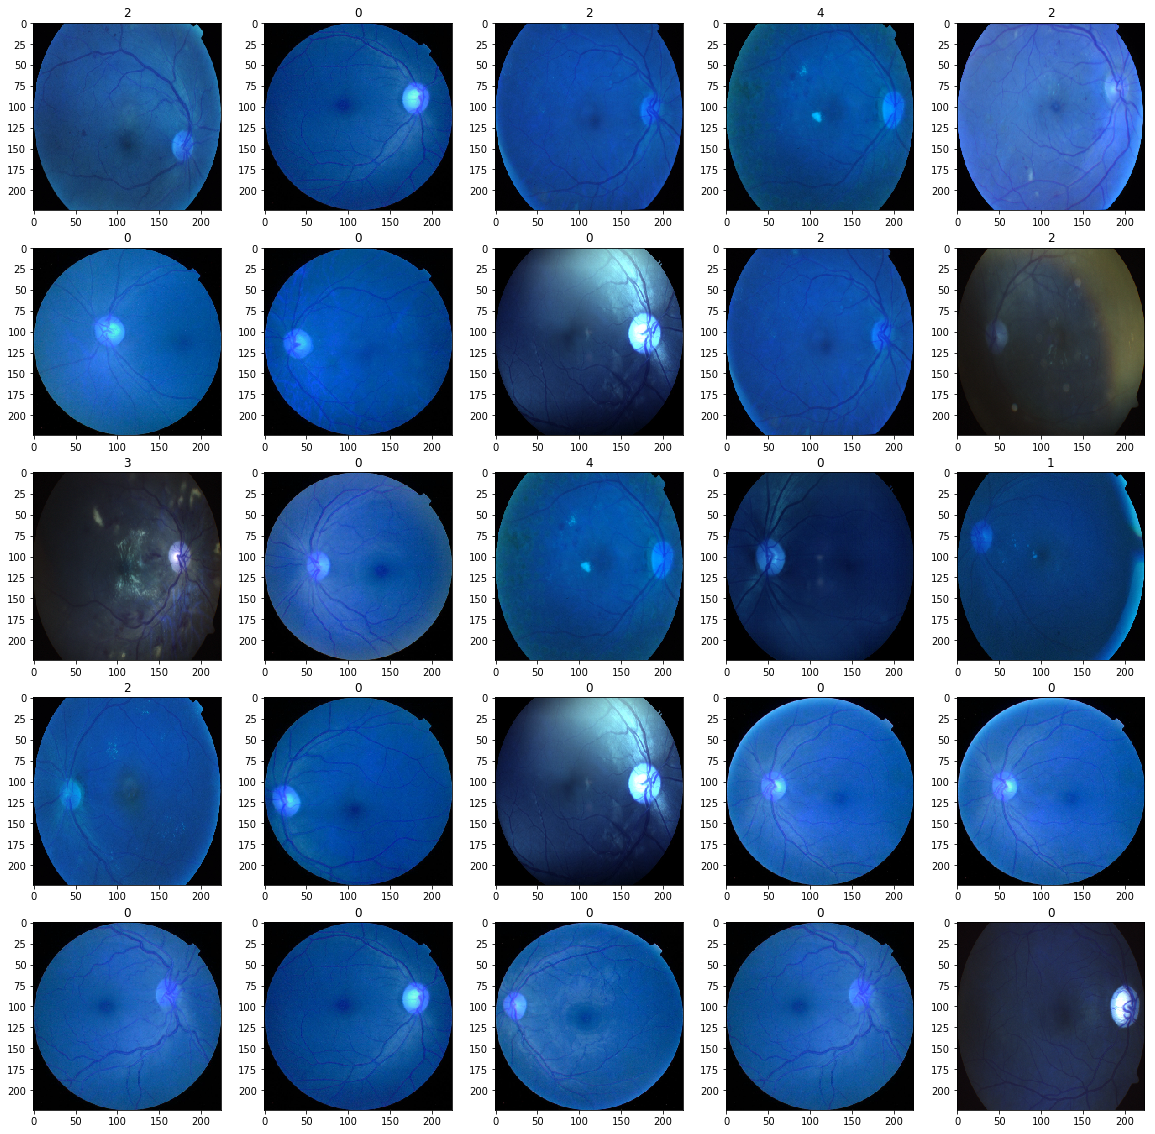

In [6]:
plt.figure(figsize=(20,20))
for i in range(1,26):
    n = np.random.randint(50)
    plt.subplot(5,5,i)
    plt.imshow(x_train[n])
    plt.title(y_train[n])

In [7]:
from keras.utils import np_utils
y_train = np_utils.to_categorical(y_train, 5)
y_valid = np_utils.to_categorical(y_valid, 5)

In [8]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_valid_multi = np.empty(y_valid.shape, dtype=y_train.dtype)
y_valid_multi[:, 4] = y_valid[:, 4]

for i in range(3, -1, -1):
    y_valid_multi[:, i] = np.logical_or(y_valid[:, i], y_valid_multi[:, i+1])

In [9]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, vertical_flip=True,
                            fill_mode='constant', cval=0.)
train_gen = datagen.flow(x_train, y_train_multi, batch_size=32)

<BarContainer object of 5 artists>

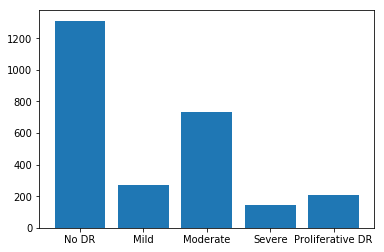

In [10]:
a=0;b=0;c=0;d=0;e=0
train_labels = []
for j in os.listdir('../input/diabetic-retinopathy/train'):
  no = csv_id.index(j[:-4])
  i = csv_diag[no]
  train_labels.append(i)
  if i == 0:
    a += 1
  if i == 1:
    b += 1
  if i == 2:
    c += 1
  if i == 3:
    d += 1
  if i == 4:
    e += 1
class_cnt = {'No DR':a , 'Mild':b, 'Moderate':c, 'Severe':d, 'Proliferative DR':e}
plt.bar(class_cnt.keys(), class_cnt.values())

In [11]:
from keras import backend as K

def sensitivity_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        sensitivity = true_positives / (possible_positives + K.epsilon())
        return sensitivity

def specificity_m(y_true, y_pred):
        true_negatives  = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
        possible_negatives  = K.sum(K.round(K.clip(1-y_true, 0, 1)))
        specificity = true_negatives / (possible_negatives + K.epsilon())
        return specificity

In [12]:
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, BatchNormalization, Flatten, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.callbacks import Callback

In [13]:
model = Sequential()
model.add(Conv2D(64, (3,3), activation='relu', input_shape=x_train.shape[1:]))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(Conv2D(512, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', sensitivity_m, specificity_m])
ck = ModelCheckpoint('dr_weights.hdf5', monitor='val_loss', save_best_only=True, mode='auto', verbose=1)
re = ReduceLROnPlateau(monitor='val_loss', mode='auto', factor=0.2, patience=5, verbose=1)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 110, 110, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 108, 108, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 106, 106, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 53, 53, 128)      

In [14]:
history = model.fit_generator(train_gen, epochs=50, steps_per_epoch=2662//32,
                     verbose=1, validation_data=(x_valid,y_valid_multi),
                    callbacks=[ck,re])

Epoch 1/50
83/83 [==============================] - 46s 553ms/step - loss: 0.6099 - accuracy: 0.7956 - sensitivity_m: 0.7486 - specificity_m: 0.8361 - val_loss: 0.7259 - val_accuracy: 0.7580 - val_sensitivity_m: 0.7469 - val_specificity_m: 0.7712

Epoch 00001: val_loss improved from inf to 0.72587, saving model to dr_weights.hdf5
Epoch 2/50
83/83 [==============================] - 41s 489ms/step - loss: 0.4556 - accuracy: 0.8389 - sensitivity_m: 0.7938 - specificity_m: 0.8764 - val_loss: 0.5546 - val_accuracy: 0.7600 - val_sensitivity_m: 0.8849 - val_specificity_m: 0.6676

Epoch 00002: val_loss improved from 0.72587 to 0.55464, saving model to dr_weights.hdf5
Epoch 3/50
83/83 [==============================] - 40s 484ms/step - loss: 0.3332 - accuracy: 0.8675 - sensitivity_m: 0.8191 - specificity_m: 0.9080 - val_loss: 0.6989 - val_accuracy: 0.7348 - val_sensitivity_m: 0.8907 - val_specificity_m: 0.6196

Epoch 00003: val_loss did not improve from 0.55464
Epoch 4/50
83/83 [===============

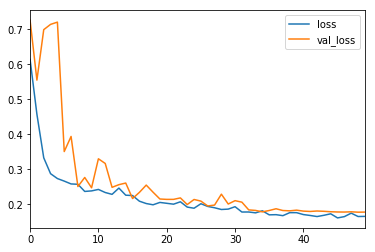

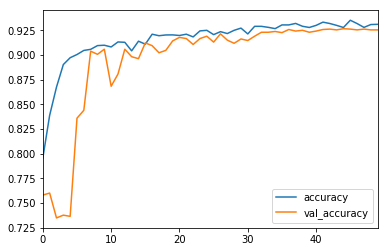

In [15]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['accuracy', 'val_accuracy']].plot()

In [16]:
x_test, y_test = data_generator(path='../input/diabetic-retinopathy/test')

y_test = np_utils.to_categorical(y_test, 5)

y_test_multi = np.empty(y_test.shape, dtype=y_test.dtype)
y_test_multi[:, 4] = y_test[:, 4]

for i in range(3, -1, -1):
    y_test_multi[:, i] = np.logical_or(y_test[:, i], y_test_multi[:, i+1])

100%|██████████| 500/500 [01:12<00:00,  6.88it/s]


In [17]:
score = model.evaluate(x_test, y_test_multi)
y_pred = model.predict(x_test)
pred = []
for i in y_pred:
    temp = []
    for j in i:
        rd = round(j)
        temp.append(rd)
    pred.append(temp)
pred = np.array(pred)
print('Test Accuracy:', score[1]*100)
print('Sensitivity:',np.array(sensitivity_m(y_test_multi, pred)))
print('Specificity:',np.array(specificity_m(y_test_multi, pred)))

500/500 [==============================] - 1s 2ms/step
Test Accuracy: 93.15999746322632
Sensitivity: 0.8741784
Specificity: 0.97421604


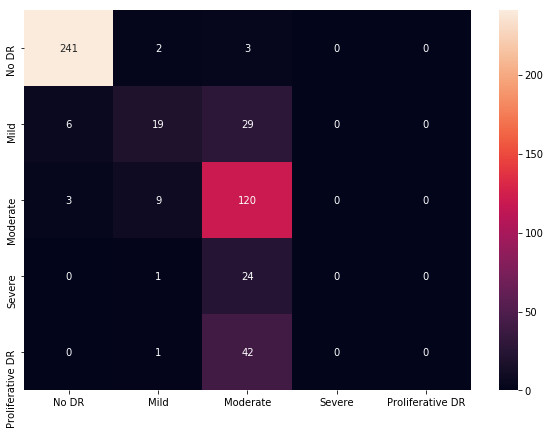

In [18]:
from mlxtend.evaluate import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

true = []
temp = pred
pred = []
classes = ['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative DR']
for i in y_test_multi:
    true.append(sum(i))
true = np.array(true)
for i in temp:
    pred.append(sum(i))
pred = np.array(pred)
cm = confusion_matrix(y_target=true,y_predicted=pred,binary=False)
df_cm = pd.DataFrame(cm, index = [i for i in classes],
                  columns = [i for i in classes])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,fmt='g')